In [1]:
# Kimlik Doğrulama.
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


# Evrişimli Sinir Ağları

## 1- Evrişimli Sinir Ağı Kullanım Alanları.

* Bilgisayarlı görü konusudur.
* Bilgisayarlı görüde , ImageNet veri seti önemli bir kırılım olmuştur.
* Derin öğrenmenin en popüler alanlarından bir tanesidir.
* Görüntü boyutu tek frame'li bir yapı olmadığı için eğer makine öğrenmesinin içerisine zaman kavramıda giriyorsa ( RNN )


## 2- Adım Adım Evrişimli Sinir Ağı.



In [ ]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"]=(5.0,4.0)
plt.rcParams["image.interpolation"]="nearest"
plt.rcParams["image.cmap"]="gray"


In [ ]:
# padding işlemi.
def zero_pad(X,pad):
  X_pad = np.pad(X, ((0,0), (pad,pad), (pad,pad), (0,0)), 'constant', constant_values = 0)
  return X_pad


In [ ]:
np.random.seed(1)
x = np.random.randn(4, 3, 3, 2) # random bir np dizisi elde ettik. matrise çevirdik.
x_pad = zero_pad(x,2) # padding uyguladık.
print("x.shape= ", x.shape)
print("x_pad.shape= ", x_pad.shape)
print("x[1,1]=", x[1,1])
print("x_pad[1,1]= ", x_pad[1,1])

fig, axarr = plt.subplots(1,2)
axarr[0].set_title('x')
axarr[0].imshow(x[0,:,:,0])
axarr[1].set_title('x_pad')
axarr[1].imshow(x_pad[0,:,:,0])

In [ ]:
# convolution işlemi
# hiperparametreler : adım kaydırma ve padding değerleridir.

def conv_single_step(a_slice_prev, W, b):
    s = np.multiply(a_slice_prev, W) + b
    Z = np.sum(s)
    return Z
np.random.seed(1)
a_slice_prev = np.random.randn(4, 4, 3)
W = np.random.randn(4, 4, 3)
b = np.random.randn(1, 1, 1)
Z = conv_single_step(a_slice_prev, W, b)
print("Z =", Z)

In [ ]:
# ileri yönte convolution fonksiyonu
def conv_forward(A_prev, W, b, hparameters):  
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    (f, f, n_C_prev, n_C) = W.shape
    stride = hparameters['stride']
    pad = hparameters['pad']
    
    n_H = int((n_H_prev - f + 2 * pad) / stride) + 1
    n_W = int((n_W_prev - f + 2 * pad) / stride) + 1

    Z = np.zeros((m, n_H, n_W, n_C))
    
    A_prev_pad = zero_pad(A_prev, pad)
  
    for i in range(m):                                 
        a_prev_pad = A_prev_pad[i]                     
        for h in range(n_H):                           
            for w in range(n_W):                      
                for c in range(n_C):                   
                    vert_start = h * stride
                    vert_end = vert_start + f
                    horiz_start = w * stride
                    horiz_end = horiz_start + f
                    a_slice_prev = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :]
                    Z[i, h, w, c] = conv_single_step(a_slice_prev, W[...,c], b[...,c])                                    

   
    assert(Z.shape == (m, n_H, n_W, n_C))
    
    cache = (A_prev, W, b, hparameters)
    
    return Z, cache

In [ ]:
np.random.seed(1)
A_prev = np.random.randn(10, 4, 4, 3)
W = np.random.randn(2, 2, 3, 8)
b = np.random.randn(1, 1, 1, 8)
hparameters = {"pad" : 2,
               "stride": 1}

Z, cache_conv = conv_forward(A_prev, W, b, hparameters)
print("Z'nin ortalaması =", np.mean(Z))
print("cache_conv[0][1][2][3] =", cache_conv[0][1][2][3])



In [ ]:
# ileri yönde ortaklama (pooling) katmanı
def pool_forward(A_prev, hparameters, mode = "max"): # max ortaklama kullanacağımızı belirttik.  
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape # giriş değerlerimizin boyutlarını belirledik.
    f = hparameters["f"]
    stride = hparameters["stride"]    
    
    # padding uygulandığında kullanacağımız pooling için çıkış değerlerimizin boyutlarının tanımlanması
    n_H = int(1 + (n_H_prev - f) / stride)
    n_W = int(1 + (n_W_prev - f) / stride)
    n_C = n_C_prev #kanal boyutlarının eşit olması gerekir. ( kural )
    
    A = np.zeros((m, n_H, n_W, n_C)) # A matrisinin ilklendirme işlemi yapıyoruz . Yani başlangıç belirliyoruz.
    
    for i in range(m):                           
        for h in range(n_H):                     
            for w in range(n_W):                 
                for c in range (n_C):            
                    
                    vert_start = h * stride
                    vert_end = vert_start + f
                    horiz_start = w * stride
                    horiz_end = horiz_start + f

                    # köşe değerlerin hesaplanması
                    a_prev_slice = A_prev[i, vert_start:vert_end, horiz_start:horiz_end, c]
                    
                    if mode == "max":
                        A[i, h, w, c] = np.max(a_prev_slice)
                    elif mode == "average":
                        A[i, h, w, c] = np.mean(a_prev_slice)
    

    
    cache = (A_prev, hparameters)
    
    assert(A.shape == (m, n_H, n_W, n_C))
    
    return A, cache

In [ ]:
np.random.seed(1)
A_prev = np.random.randn(2, 4, 4, 3)
hparameters = {"stride" : 1, "f": 4}

A, cache = pool_forward(A_prev, hparameters)
print("pooling türü = max")
print("A =", A)
print()
A, cache = pool_forward(A_prev, hparameters, mode = "average")
print("pooling türü = average")
print("A =", A)

In [ ]:
# Genel YSA modelinde ki Ağırlık, Bias ve Giriş değerlerini hesapladık ve Cache'de tutuyoruz. Şimdi ise geri besleme yapacağız.
# Bu işlem için türev kullanıyoruz.

def conv_backward(dZ, cache):
    (A_prev, W, b, hparameters) = cache #cache de ki değerleri değişkenlerimize atadık.
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    (f, f, n_C_prev, n_C) = W.shape
    stride = hparameters["stride"]
    pad = hparameters["pad"]
    (m, n_H, n_W, n_C) = dZ.shape
    dA_prev = np.zeros((m, n_H_prev, n_W_prev, n_C_prev))                           
    dW = np.zeros((f, f, n_C_prev, n_C))
    db = np.zeros((1, 1, 1, n_C))
    A_prev_pad = zero_pad(A_prev, pad)
    dA_prev_pad = zero_pad(dA_prev, pad)
    
    for i in range(m):                       

        a_prev_pad = A_prev_pad[i]
        da_prev_pad = dA_prev_pad[i]
        
        for h in range(n_H):                   
            for w in range(n_W):              
                for c in range(n_C):           
                    
                    vert_start = h * stride
                    vert_end = vert_start + f
                    horiz_start = w * stride
                    horiz_end = horiz_start + f
                    
                    a_slice = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :]

                    da_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :] += W[:,:,:,c] * dZ[i, h, w, c]
                    dW[:,:,:,c] += a_slice * dZ[i, h, w, c]
                    db[:,:,:,c] += dZ[i, h, w, c]

        dA_prev[i, :, :, :] = da_prev_pad[pad:-pad, pad:-pad, :]

    assert(dA_prev.shape == (m, n_H_prev, n_W_prev, n_C_prev))
    
    return dA_prev, dW, db

In [ ]:
np.random.seed(1)
dA, dW, db = conv_backward(Z, cache_conv)
print("Giriş değerlerinin türevinin ortalaması =", np.mean(dA))
print("Ağırlığın türevinin ortalaması =", np.mean(dW))
print("Bias'ın türevinin ortalaması =", np.mean(db))


In [ ]:
# filtre tanımlaması ve max pooling uygulaması
def create_mask_from_window(x):
    mask = x == np.max(x) # max ortaklamada geriye yayılıma etki eden max değeridir.
    return mask

In [ ]:
np.random.seed(1)
x = np.random.randn(2,3)
mask = create_mask_from_window(x)
print('x = ', x)
print("mask = ", mask)

In [ ]:
# ortalama pooling uygulaması
def distribute_value(dz, shape):
    (n_H, n_W) = shape
    average = dz / (n_H * n_W)
    a = np.ones(shape) * average # ortalama ortaklamada geriye yayılıma etki eden matrisin ortalama değeridir.
    return a

In [ ]:
a = distribute_value(2, (2,2))
print('dağıtılmış değer =', a)

In [ ]:
def pool_backward(dA, cache, mode = "max"):
    (A_prev, hparameters) = cache
    
    stride = hparameters["stride"]
    f = hparameters["f"]
    
    m, n_H_prev, n_W_prev, n_C_prev = A_prev.shape
    m, n_H, n_W, n_C = dA.shape
    
    dA_prev = np.zeros(A_prev.shape)
    
    for i in range(m):                       
        a_prev = A_prev[i]
        for h in range(n_H):                   
            for w in range(n_W):              
                for c in range(n_C):          
                    vert_start = h
                    vert_end = vert_start + f
                    horiz_start = w
                    horiz_end = horiz_start + f
                    if mode == "max":
                        a_prev_slice = a_prev[vert_start:vert_end, horiz_start:horiz_end, c]
                        mask = create_mask_from_window(a_prev_slice)
                        dA_prev[i, vert_start:vert_end, horiz_start:horiz_end, c] += np.multiply(mask, dA[i, h, w, c])
                        
                    elif mode == "average":
                        da = dA[i, h, w, c]
                        shape = (f, f)
                        dA_prev[i, vert_start:vert_end, horiz_start:horiz_end, c] += distribute_value(da, shape)

    assert(dA_prev.shape == A_prev.shape)
    
    return dA_prev

In [ ]:
np.random.seed(1)
A_prev = np.random.randn(5, 5, 3, 2)
hparameters = {"stride" : 1, "f": 2}
A, cache = pool_forward(A_prev, hparameters)
dA = np.random.randn(5, 4, 2, 2)

dA_prev = pool_backward(dA, cache, mode = "max")
print("kullanılan pooling = max")
print('dA ortalama = ', np.mean(dA))
print('dA_prev[1,1] = ', dA_prev[1,1])  
print()
dA_prev = pool_backward(dA, cache, mode = "average")
print("kullanılan pooling = average")
print('dA ortalama = ', np.mean(dA))
print('dA_prev[1,1] = ', dA_prev[1,1])

kullanılan pooling = max
dA ortalama =  0.14571390272918056
dA_prev[1,1] =  [[ 0.          0.        ]
 [ 5.05844394 -1.68282702]
 [ 0.          0.        ]]

kullanılan pooling = average
dA ortalama =  0.14571390272918056
dA_prev[1,1] =  [[ 0.08485462  0.2787552 ]
 [ 1.26461098 -0.25749373]
 [ 1.17975636 -0.53624893]]


## 3- Uygulama_RakamTanima / MNIST.

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

In [ ]:
# uygulama başlangıcı
from __future__ import print_function
import keras
import tensorflow as tf
from keras.datasets import mnist
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras. layers import Conv2D, MaxPooling2D
from keras import backend as K

import matplotlib.pyplot as plt

In [ ]:
# veri setinin yüklenmesi
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [ ]:
# veriden görselleştirme
plt.figure(figsize=(14,14))
x, y = 10, 4 
for i in range(40):  
    plt.subplot(y, x, i+1)
    plt.imshow(x_train[i])
plt.show()

In [ ]:

batch_size = 128 
num_classes = 10 
epochs = 6 #12 epoch önerilir

img_rows, img_cols = 28, 28


if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [ ]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [ ]:
# model oluşturma
model = Sequential() 

In [ ]:
# katmanların oluşturulması
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))

 
model.add(Conv2D(64, (3, 3), activation='relu'))


model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Dropout(0.25))


model.add(Flatten())


model.add(Dense(128, activation='relu'))

model.add(Dropout(0.5))


model.add(Dense(num_classes, activation='softmax'))

In [ ]:
# modelimize göz atalım
model.summary() # 1,199,882 parametleri bir modelimiz var.

In [ ]:
# modelimizi derleyelim.
model.compile(loss = keras.losses.categorical_crossentropy,
             optimizer = tf.keras.optimizers.Adadelta(),
             metrics = ['accuracy'])

In [ ]:
# modelimizin eğitilmesi.
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

In [ ]:
# modelin kaydedilmesi.
model_test = model.save('/content/drive/MyDrive/mnist_model.h5')

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test Loss:', score[0])
print('Test Accuracy:', score[1])

In [ ]:
# rastgele bir değer için test işlemi.
model_test = model.save('/content/drive/MyDrive/mnist_model.h5')

In [ ]:
test_image = x_test[128]
y_test[128]

In [ ]:
plt.imshow(test_image.reshape(28,28))

In [ ]:
test_data = x_test[128].reshape(1,28,28,1)
pred = model.predict(test_data,batch_size=1)
print(pred)

## 4- Uygulama_GoruntuTanıma / MNIST.

In [ ]:
# kütüphanelerin yüklenmesi
from __future__ import print_function
import keras
from keras.datasets import fashion_mnist
from keras.models import load_model
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
import random

In [ ]:
# verilerin yüklenmesi
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'eğitim örnekleri')
print(x_test.shape[0], 'test örnekleri')

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

In [ ]:
# veriyi görelim
plt.imshow(x_train[10])

In [ ]:
# fashion mnist etiket isimleri
fashion_mnist_labels = np.array([
    'Tişört/Üst',
    'Pantolon',
    'Kazak',
    'Elbise',
    'Ceket',
    'Sandalet',
    'Gömlek',
    'Sneaker',
    'Çanta',
    'Bilekte Bot'])

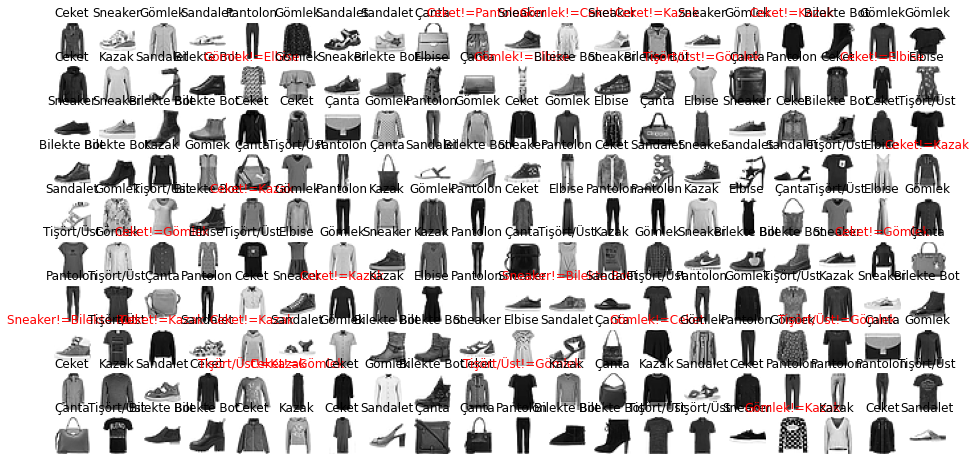

Doğru tahminlerin sayısı: 177
Hata sayısı: 23
Doğru tahmin oranı: 88.5 %


In [ ]:
# Daha önce eğitilmiş olan modelin ağırlıklarınımodel_fashion-mnist_cnn_train2_epoch24.h5dosyasından çekelim 
# Ve giriş görüntülerini model girişine uygun şekilde ön işlemlerden geçirelim!

model = load_model('/content/drive/MyDrive/model_fashion-mnist_cnn_train2_epoch24.h5')

    
def convertMnistData(image):
    img = image.astype('float32')
    img /= 255

    return image.reshape(1,28,28,1)

plt.figure(figsize=(16,16))

right = 0
mistake = 0
prefictionNum = 200

for i in range(prefictionNum):
    index = random.randint(0, x_test.shape[0])
    image = x_test[index]
    data = convertMnistData(image)

    plt.subplot(20, 20, i+1)
    plt.imshow(image,  cmap=cm.gray_r)
    plt.axis('off')

    ret = model.predict(data, batch_size=1) 
    #yazdır(ret)

    bestnum = 0.0
    bestclass = 0
    for n in [0,1,2,3,4,5,6,7,8,9]:
        if bestnum < ret[0][n]:
            bestnum = ret[0][n]
            bestclass = n

    if y_test[index] == bestclass:
        plt.title(fashion_mnist_labels[bestclass])
        right += 1
    else:
        #tahmin edilen sınıf != gerçek sınıf
        plt.title(fashion_mnist_labels[bestclass] + "!=" + fashion_mnist_labels[y_test[index]], color='#ff0000')
        mistake += 1
                                                                   
plt.show()
print("Doğru tahminlerin sayısı:", right)
print("Hata sayısı:", mistake)
print("Doğru tahmin oranı:", right/(mistake + right)*100, '%')

## 5- Uygulama_ImageNet-VGG16-Nesne-Tanıma.


* `ImageNet projesi`, görsel nesne tanıma yazılımı araştırmasında kullanılmak üzere tasarlanmış geniş bir görsel veritabanıdır.
* On milyondan fazla etiketli resim bulunmaktadır.
* ImageNet veri setinde önceden eğitilmiş bir modeli göreceğiz. 16 katmanlı VGG Net (VGG16) modelini kullanacağız
* VGG16 bu modeli daha önce pytorch üzerinde adım adım kodlamıştık. Github repo'muzda bulabilirsiniz.


In [ ]:
# ilgili kütüphanelerin yüklenmesi
import numpy as np
from PIL import Image

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions

In [ ]:
# keras üzerinde ımagenet ile eğitilmiş olan modeli yükleme 
model = VGG16(weights = 'imagenet', include_top=True)

In [ ]:
# modelin yapısına bir göz atalım, hangi katmanlar var ve katmanların özellikleri neler?
layers = dict([(layer.name, layer.output) for layer in model.layers])
layers


In [ ]:
# toplam parametre sayısı bize modelin büyüklüğü hakkında bilgi verecektir.
model.count_params()

In [ ]:
# drive üzerinde bulunan ve bizim tahmin etmede kullanacağımız test veri setine göz atalım.
# /content/drive/MyDrive/ dizini altındaki images klasörümüzü alıyoruz.
import os
os.chdir("/gdrive/MyDrive/datasets/images")


In [ ]:
!ls

In [ ]:
# test resmi yükleyelim ve ön işlemler yapalım
image_path = 'bilgisayar.jpg'
image = Image.open(image_path) 
image = image.resize((224, 224))
image

In [ ]:
x = np.array(image, dtype = 'float32') #görüntüyü diziye çevirir
x = np.expand_dims(x, axis=0) #dizi listesine çevirir
x= preprocess_input(x)

In [ ]:
# ve işte magic :)
# test görüntüsü ile sınıflama yapma
preds = model.predict(x)
print('predicted:', decode_predictions(preds, top=3)[0])

In [ ]:
print(decode_predictions(preds, top=1)[0][0][1])

notebook


## 6- Uygulama_ImageNet-ResNet50-Nesne-Tanıma.

In [2]:
# ilgili kütüphanelerin yüklenmesi
from keras.applications.resnet import ResNet50
from keras.preprocessing.image import img_to_array
from keras.applications import imagenet_utils
from PIL import Image
import numpy as np
from io import BytesIO
import os
import requests

In [ ]:
# modelin yüklenmesi
model = ResNet50(weights="imagenet")

In [4]:
# resmi girişe uygun formata getirmek için yeniden boyutlandırma fonksiyonu tanımlıyoruz.
def prepare_image(image, target):
	# giriş görüntüsünü yeniden boyutlandırma ve ön işlemerin yapılması
	image = image.resize(target)
	image = img_to_array(image)
	image = np.expand_dims(image, axis=0)
	image = imagenet_utils.preprocess_input(image)

	# işlenmiş görüntüyü alma
	return image

In [5]:
# sınıflandırmak istediğiniz resmin web adresini linke girebiliriz.
ImageURL = "https://fidansepetim.com/uploads/p/p/3-Yas-Asili-Granny-Smith-Elma-Fidani-Yesil-Mayhos_1.jpg" #@param {type:"string"}


In [ ]:
# girdiğimiz web adresindeki resim indiriliyor.
response = requests.get(ImageURL)
image = Image.open(BytesIO(response.content))
image

In [ ]:
# eğitilmiş model ile sınıflandırma yapılıyor.
data = {"success": False}

pre_image = prepare_image(image, target=(224, 224)) # 224 x 224 boyutlu hale getir

preds = model.predict(pre_image) # Kesirim modeline ön işlemden geçmiş görüntüyü uygula

results = imagenet_utils.decode_predictions(preds) #kestirim
data["predictions"] = []


for (imagenetID, label, prob) in results[0]: # ImageNet veri kümseinden etiket, olasılık ve kestrim sonucunu al
  r = {"label": label, "probability": float(prob)}
  data["predictions"].append(r)
  
data["success"] = True

print(data)

In [8]:
# en yüksek olasılıklı sonucu ekrana yazdırıyoruz.
print("Sınıflandırma tahmini en yüksek olan {0} oranıyla {1}'dır.".format(data["predictions"][0]["probability"],data["predictions"][0]["label"])) 

Sınıflandırma tahmini en yüksek olan 0.9391114115715027 oranıyla Granny_Smith'dır.
